## replicate tops cross validation pipeline

Model selection in the tops paper used multiple criterias to test for 
* model sensitivity (CV)
* model specificity (CV)

in 2 datasets
* test dataset of study 1 (the original dataset used to train the model)
* an independent dataset with identical aqcuisition to study1

then summarised all these metrics into a single metric to determine the best fit model.

### load dcc matrix and ratings

In [18]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [86]:
dat = pickle.load(open('study3_reduced.p','rb'))

study 3 has 4 sets of data with 48 subjects:
* capsaicin pain (CAPS)
* control with no pain (REST)
* quinine aversive taste (QUIN)
* aversive odor (ODOR)

The pain/aversive ratings and DCC functional connectivity matrices were provided by the authors. For computing efficency, the matrices were reduced (downsampled every 10 values).

In [87]:
data = {}
for key, item in dat.items():
    dat_tmp = item
    for key_cond, item_cond in item.items():
#         print(key, key_cond)
        data[key+'_'+key_cond] = np.array(item_cond)

In [88]:
data['pain_REST'].shape

(48, 10)

Plotting ratings from 4 datasets

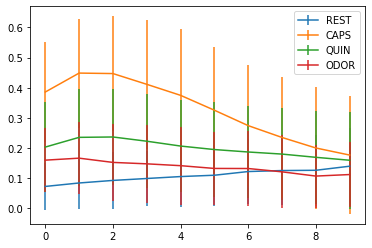

In [89]:
conds = ['REST', 'CAPS', 'QUIN', 'ODOR']
for c in conds:
    key = 'pain_'+c
    _ = plt.errorbar(np.arange(0,10), np.mean(data[key],axis=0), np.std(data[key],axis=0), label=c)
plt.legend()

### model training
we use half the subjects (n=24) for training, leaving the rest for testing (pretending it's a validation study like study 2). Like in the paper, we train with CAPS and REST conditions by concatenating them.

In [245]:
data_train = {}
data_test = {}
for key, item in data.items():
    data_train[key] = item[:24,:]
    data_test[key] = item[24:,:]

In [246]:
data['dcc_reduced_REST'].shape

(48, 388, 10)

In [247]:
data_train['dcc_reduced_REST'].shape

(24, 388, 10)

We use PCA to reduce each DCC FC matrix to a reduced number of PCs, and train a regression model with these PCs (PCR). Since we can use an arbitrary number of PCs, this is our hyperparameter we'll optimise with a set of criteria.

In [248]:
# combining CAPS and REST (study1)
data1 = {}
data1['dcc'] = np.concatenate([data_train['dcc_reduced_CAPS'],data_train['dcc_reduced_REST']], axis=2)
data1['rate'] = np.concatenate([data_train['pain_CAPS'],data_train['pain_REST']], axis=1)

In [249]:
# combining CAPS and REST (study2)
data2 = {}
data2['dcc'] = np.concatenate([data_test['dcc_reduced_CAPS'],data_test['dcc_reduced_REST']], axis=2)
data2['rate'] = np.concatenate([data_test['pain_CAPS'],data_test['pain_REST']], axis=1)

In [250]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

### Criterion 1: within-individual prediction (study1)

Calculate Pearson's correlation values between actual and predicted ratings for each participant, then average the correlation coefficients to obtain 1 value per model.

In [314]:
# reshape all subjects
sj_num = data1['dcc'].shape[0]
dcc_num = data1['dcc'].shape[1]
timebin_num = data1['dcc'].shape[2]
dcc = data1['dcc'].reshape((dcc_num, timebin_num*sj_num))
rate = data1['rate'].reshape(sj_num*rate_num)
# PCA for all subjects (do this once only for each model)
dcc_pca, evectors, evals = pca(dcc.T, n_components=15)

In [315]:
# how it's done in 1 subject
# regression model
X = dcc_pca[:20,:]
y = rate[:20]
regr = linear_model.LinearRegression()
regr.fit(X, y)
# make predictions
y_pred = regr.predict(X)
# calculate correlation
np.corrcoef(y, y_pred)

array([[1.        , 0.97887174],
       [0.97887174, 1.        ]])

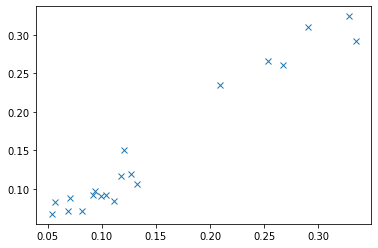

In [316]:
plt.plot(y,y_pred,'x', label='subject 0')

In [317]:
# how it's done in all subject
# regression model
X = dcc_pca
y = rate
regr = linear_model.LinearRegression()
regr.fit(X, y)
# make predictions
y_pred = regr.predict(X)
# calculate correlation
np.corrcoef(y, y_pred)
# get weights
w1 = regr.coef_
print(w1.shape)

(15,)


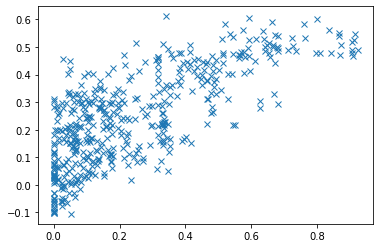

In [318]:
plt.plot(y,y_pred,'x', label='all subjects (study1)')

In [319]:
def criterion1(dcc_pca, rate, sj_num, timebin_num, dcc_num):
    # leave one subject out CV
    corr_coefs_c1 = np.empty((sj_num,))
    for sj in range(sj_num):
        test_idx = np.arange(sj*timebin_num,(sj+1)*timebin_num)
        train_idx = np.concatenate([np.arange(0,sj*timebin_num), 
                                    np.arange((sj+1)*timebin_num, sj_num*timebin_num)])
        y_test = rate[test_idx]
        X_test = dcc_pca[test_idx, :]
        y_train = rate[train_idx]
        X_train = dcc_pca[train_idx, :]
        # regression model
        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)
        # make predictions
        y_pred = regr.predict(X_test)
        # calculate correlation
        corr_coefs_c1[sj] = np.corrcoef(y_test, y_pred)[0,1]
    return corr_coefs_c1

In [320]:
# calculate
corr_coefs_c1 = criterion1(dcc_pca, rate, sj_num, timebin_num, dcc_num)
# mean CV within subject correlation
print(np.mean(corr_coefs_c1))
s1 = np.mean(corr_coefs_c1)

0.7462057798007957


### Criterion 2: between-individual prediction in study1
Calculate Pearson's correlation between averaged actual and predicted pain ratings for each condition across subject (1 subject has 2 ratings, CAPS and REST).

In [321]:
# using all subjects
rate_mean = rate.transpose().reshape(-1,timebin_num).mean(1).reshape(-1).transpose()
dcc_mean = dcc_pca.transpose().reshape(-1,timebin_num).mean(1).reshape(15, -1).transpose()
# regression model
regr = linear_model.LinearRegression()
regr.fit(dcc_mean, rate_mean)
# make predictions
y_pred = regr.predict(dcc_mean)
# weights
w2 = regr.coef_

In [322]:
w2.shape

(15,)

In [323]:
def criterion2(dcc_pca, rate, sj_num, timebin_num, dcc_num):
    # leave one subject out CV
    corr_coefs_c2 = np.empty((sj_num,))
    # mean time bins within subject (taking mean of ratings within condition)
    rate_mean = rate.transpose().reshape(-1,timebin_num).mean(1).reshape(-1).transpose()
    dcc_mean = dcc_pca.transpose().reshape(-1,timebin_num).mean(1).reshape(15, -1).transpose()
    # regression
    for sj in range(sj_num):
        test_idx = np.arange(sj*2,(sj+1)*2)
        train_idx = np.concatenate([np.arange(0,sj*2), 
                                    np.arange((sj+1)*2, sj_num*2)])
        y_test = rate[test_idx]
        X_test = dcc_pca[test_idx, :]
        y_train = rate[train_idx]
        X_train = dcc_pca[train_idx, :]
        # regression model
        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)
        # make predictions
        y_pred = regr.predict(X_test)
        # calculate correlation
        corr_coefs_c2[sj] = np.corrcoef(y_test, y_pred)[0,1]
    return corr_coefs_c2

In [324]:
# calculate
corr_coefs_c2 = criterion2(dcc_pca, rate, sj_num, timebin_num, dcc_num)
# mean CV across subject correlation (2 data points left, corrcoef 1 or -1)
print(np.mean(corr_coefs_c2))
s2 = np.mean(corr_coefs_c2)

0.08333333333333333


### Criterion 3: classification of capsaicin vs control in study1
2 alternative forced choice classification, compare paired values (1 CAPS and 1 REST predicted value, CAPS should be larger than REST) for each individual.

In [325]:
def criterion3(dcc_pca, rate, sj_num, timebin_num, dcc_num):
    # using similar method to 2
    correct_percent_c3 = np.zeros((sj_num,))
    # mean time bins within subject (taking mean of ratings within condition)
    rate_mean = rate.transpose().reshape(-1,timebin_num).mean(1).reshape(-1).transpose()
    dcc_mean = dcc_pca.transpose().reshape(-1,timebin_num).mean(1).reshape(15, -1).transpose()
    # regression
    for sj in range(sj_num):
        test_idx = np.arange(sj*2,(sj+1)*2)
        train_idx = np.concatenate([np.arange(0,sj*2), 
                                    np.arange((sj+1)*2, sj_num*2)])
        y_test = rate[test_idx]
        X_test = dcc_pca[test_idx, :]
        y_train = rate[train_idx]
        X_train = dcc_pca[train_idx, :]
        # regression model
        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)
        # make predictions
        y_pred = regr.predict(X_test)
    #     calculate correct percentage
    #     print(y_pred)
        if y_pred[0]>y_pred[1]: # CAPS>REST
            correct_percent_c3[sj] = 1
    return correct_percent_c3

In [326]:
# calculate correct percentage
correct_percent_c3 = criterion3(dcc_pca, rate, sj_num, timebin_num, dcc_num)
# mean
print(np.mean(correct_percent_c3))
s3 = np.mean(correct_percent_c3)

0.6666666666666666


### Criterion 4: within individual prediction in study2
Similar to model 1, but using a new dataset (not used CV in the paper)

In [327]:
# reshape all subjects
sj_num = data2['dcc'].shape[0]
dcc_num = data2['dcc'].shape[1]
timebin_num = data2['dcc'].shape[2]
dcc = data2['dcc'].reshape((dcc_num, timebin_num*sj_num))
rate = data2['rate'].reshape(sj_num*rate_num)
# PCA for all subjects (do this once only for each model)
dcc_pca, evectors, evals = pca(dcc.T, n_components=15)

In [328]:
# applying weights from 1 to study2 data
X = dcc_pca
y_pred = np.dot(X, w1)

In [330]:
# correlation coefficient
corr_coefs_c4 = np.corrcoef(rate, y_pred)[0,1]
print(corr_coefs_c4)
s4 = corr_coefs_c4

0.12761027769481476


### Criterion 5: between-subject prediction in study2
similar to criterion 2, but using data from study 2 (no CV)

In [331]:
# taking mean of timebins
rate_mean = rate.transpose().reshape(-1,timebin_num).mean(1).reshape(-1).transpose()
dcc_mean = dcc_pca.transpose().reshape(-1,timebin_num).mean(1).reshape(15, -1).transpose()
# applying weights from 2 to study 2 data
X = dcc_mean
y_pred = np.dot(X, w2)

In [333]:
# correlation coefficient
corr_coefs_c5 = np.corrcoef(rate_mean, y_pred)[0,1]
print(corr_coefs_c5)
s5 = corr_coefs_c5

-0.012680984874434519


### Criterion 6: classification of capsaicin vs control in study2
similar to criterion 3, using study 2 data (no cv)

In [334]:
# using same w2 weights
X = dcc_mean
y_pred = np.dot(X, w2)

In [335]:
# separating in conditions
y_pred_CAPS = y_pred[::2]
y_pred_REST = y_pred[1::2]

In [337]:
# calculating prediction accuracy
print(np.mean(y_pred_CAPS>y_pred_REST))
s6 = np.mean(y_pred_CAPS>y_pred_REST)

0.6666666666666666


### Criterion 7: classification of capsaicin vs quinine in study2
this examines the model specificity to see if it discriminates pain from non-painful aversive condition (quinine). Similar to 6, but comparing CAPS and QUIN.

In [338]:
# combining CAPS and QUIN (study2)
data2a = {}
data2a['dcc'] = np.concatenate([data_test['dcc_reduced_CAPS'],data_test['dcc_reduced_QUIN']], axis=2)
data2a['rate'] = np.concatenate([data_test['pain_CAPS'],data_test['pain_QUIN']], axis=1)

In [339]:
# reshape all subjects
sj_num = data2a['dcc'].shape[0]
dcc_num = data2a['dcc'].shape[1]
timebin_num = data2a['dcc'].shape[2]
dcc = data2a['dcc'].reshape((dcc_num, timebin_num*sj_num))
rate = data2a['rate'].reshape(sj_num*rate_num)
# PCA for all subjects (do this once only for each model)
dcc_pca, evectors, evals = pca(dcc.T, n_components=15)

In [340]:
# taking mean of timebins
rate_mean = rate.transpose().reshape(-1,timebin_num).mean(1).reshape(-1).transpose()
dcc_mean = dcc_pca.transpose().reshape(-1,timebin_num).mean(1).reshape(15, -1).transpose()
# using same w2 weights
X = dcc_mean
y_pred = np.dot(X, w2)

In [341]:
# separating in conditions
y_pred_CAPS = y_pred[::2]
y_pred_QUIN = y_pred[1::2]

In [342]:
# calculating prediction accuracy
s7 = np.mean(y_pred_CAPS>y_pred_QUIN)
print(s7)

0.4166666666666667


### Taking it all together
The final model performance score is calculated as:

$$ P_{i,j} = (S_{i,j}-minV_j) / (maxV_j-minV_j) * 100$$

where $S_{i,j}$ is the raw performance score for ith model and jth criterion. Vj is vectorised $S_{i,j}$ across models, and $P_{i,j}$ is the normalised score.

Therefore, for 279 brain parcellation, DCC correlation, PCR with 15 PCs, this particular model has final score of: 

In [343]:
s_ij = np.array([s1, s2, s3, s4, s5, s6, s7])

In [346]:
p_ij = (s_ij-min(s_ij))/(max(s_ij)-min(s_ij))*100
print(p_ij)
print(sum(p_ij))

[100.          12.65199535  89.51897479  18.48645531   0.
  89.51897479  56.5759836 ]
366.7523838377458


highest possible score will be 700, while this particular model has 366.

We can repeat the procedure for different parameters and find the best combination.

### the end

### helper functions

#### PCA

In [50]:
# reducing DCC_out to 21PC
def get_sample_cov_matrix(X):
    """
    Returns the sample covariance matrix of data X
    Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    Returns:
    (numpy array of floats)   : Covariance matrix
    """

    # Subtract the mean of X
    X = X - np.mean(X, 0)
    # Calculate the covariance matrix (hint: use np.matmul)
    cov_matrix =  1 / X.shape[0] * np.matmul(X.T, X)

    return cov_matrix

def sort_evals_descending(evals, evectors, n_components=None):
    """
    Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
    eigenvectors to be in first two quadrants (if 2D).

    Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

    Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
    """

    index = np.flip(np.argsort(evals))
    if n_components is not None:
        index = index[:n_components]
    evals = evals[index]
    evectors = evectors[:, index]
#     if evals.shape[0] == 2:
#         if np.arccos(np.matmul(evectors[:, 0],
#                            1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2: evectors[:, 0] = -evectors[:, 0]
#         if np.arccos(np.matmul(evectors[:, 1],
#                            1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:evectors[:, 1] = -evectors[:, 1]
    return evals, evectors

def change_of_basis(X, W):
    """
    Projects data onto a new basis.

    Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

    Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
    """

    Y = np.matmul(X, W)
    return Y


def pca(X, n_components):
    """
    Performs PCA on multivariate data.
    Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    Returns:
    (numpy array of floats)   : Data projected onto the new basis
    (numpy array of floats)   : Vector of eigenvalues
    (numpy array of floats)   : Corresponding matrix of eigenvectors
    """

    # Subtract the mean of X
    X = X - np.mean(X, axis=0)
    # Calculate the sample covariance matrix
    cov_matrix = get_sample_cov_matrix(X)
    # Calculate the eigenvalues and eigenvectors
    evals, evectors = np.linalg.eigh(cov_matrix)
    # Sort the eigenvalues in descending order
    evals, evectors = sort_evals_descending(evals, evectors, n_components)
    # Project the data onto the new eigenvector basis
    score = change_of_basis(X, evectors)

    return score, evectors, evals

#### reduce dcc matrix size

In [80]:
# helper functions to load mat
import scipy.io as spio
import numpy as np


def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [81]:
main_mat = './data/whole_participants/FC_and_pain/study3.mat'

In [82]:
m = loadmat(main_mat)

In [83]:
# reduce size of dcc
m['dcc_reduced'] = {}
for key, item in m['dcc'].items():
    print(key)
    tmp_ls = []
    for subj in range(len(item)):
        tmp_ls.append(item[subj][::100])
    m['dcc_reduced'][key] = tmp_ls

REST
CAPS
QUIN
ODOR


In [84]:
mr = {'dcc_reduced':m['dcc_reduced'], 'pain':m['pain']}

In [85]:
import pickle
pickle.dump(mr,open('study3_reduced.p','wb'))